# BERT & TF

In [38]:
!pip install tensorflow==2.1.0

In [39]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
import pickle as pk
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm_notebook
from collections import defaultdict
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

tf.__version__

'2.1.0'

In [40]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Data - Latest Data Split - Blind

In [41]:
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv

--2020-03-04 21:21:31--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6523814 (6.2M) [text/plain]
Saving to: ‘articles_train.csv.1’

articles_train.csv. 100%[===================>]   6.22M  --.-KB/s    in 0.05s   

2020-03-04 21:21:31 (123 MB/s) - ‘articles_train.csv.1’ saved [6523814/6523814]

--2020-03-04 21:21:41--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.13

In [0]:
data_train = pd.read_csv("articles_train.csv")
data_test = pd.read_csv("articles_test.csv")

In [0]:
data_train.head()

,content_id,month,day,year,date,content_source_desc,content_title_clean,content_body_clean,blind_mean_rating,blind_rating_count,blind_ratings
0,2932,11,2,2017,2017-11-02,The New York Times,A Tax Cut That Lifts the Economy? Opinions Are...,Yet if the House plan resolves some longstandi...,3.177778,45,"[4.5, 1.5, 0.5, 4.5, 1.0, 4.0, 3.5, 3.5, 1.5, ..."
1,2870,11,1,2017,2017-11-01,Fox News,"Tom Tancredo enters Colorado governor's race, ...",Former U.S. Rep. Tom Tancredo announced Tuesda...,2.375000,16,"[3.5, 4.0, 3.0, 2.5, 0.5, 3.0, 0.5, 0.5, 4.5, ..."
2,2869,11,1,2017,2017-11-01,The New York Times,Panel Recommends Opioid Solutions but Puts No ...,President Trump’s bipartisan commission on th...,3.916667,6,"[5.0, 4.0, 4.5, 3.5, 2.0, 4.5]"
3,2864,11,1,2017,2017-11-01,Fox News,"Trump vows to end non merit-base immigration, ...",President Trump vowed Wednesday to scrap the f...,2.100000,5,"[2.0, 2.5, 4.0, 0.5, 1.5]"
4,2868,11,1,2017,2017-11-01,Breitbart,WATCH: Congress Holds Hearing on Banning Abort...,Congress will hold a hearing Wednesday on a bi...,2.428571,21,"[2.0, 1.0, 0.5, 1.0, 3.5, 5.0, 2.0, 0.5, 2.5, ..."


In [0]:
#clean data
def clean_data(text):
    #remove punctuation, digits, extra stuff. make lowercase
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    #lemma it - include POS tag in order to lemma it better
    tag_map = defaultdict(lambda : wordnet.NOUN)
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV
    lemmatizer = WordNetLemmatizer()
    textTokens = word_tokenize(text)
    #remove stopwords
    word_tokens_nostop = [w for w in textTokens if not w in stopwords.words('english')] 
    #now lemma
    text = [lemmatizer.lemmatize(tok, tag_map[tag[0]]) for tok, tag in pos_tag(word_tokens_nostop)]
    return " ".join(text)

### Get clean body

In [0]:
clean_body_train = data_train["content_body_clean"].apply(clean_data)
y_train = data_train['blind_mean_rating']

clean_body_test = data_test["content_body_clean"].apply(clean_data)
y_test = data_test['blind_mean_rating']

In [0]:
source_train = pd.get_dummies(data_train['content_source_desc'])
source_test = pd.get_dummies(data_test['content_source_desc'])

In [0]:
source_train.shape

(1301, 7)

### Split train and val

In [0]:
X_train, X_val, y_train_t, y_val, source_train_t, source_val = train_test_split(clean_body_train, y_train, source_train, test_size=0.15, shuffle=True, random_state=3)

In [0]:
y_train_std = np.array(list(y_train_t))
y_val_std = np.array(list(y_val))
y_test_std = np.array(list(y_test))

### Word2Vec Embeddings

In [0]:
EMBED_DIM = 64

In [0]:
train_body = []
articles = list(clean_body_train)

for article in articles:
    art_tokens = word_tokenize(article)
    train_body.append(art_tokens)

In [0]:
len(train_body)

1301

In [0]:
import gensim

# train word2vec model
modelw2 = gensim.models.Word2Vec(sentences=train_body, size=EMBED_DIM, window=5, workers=4, min_count=1)
# vocab size
total_words = list(modelw2.wv.vocab)
print("Vocab size",len(total_words))

Vocab size 29377


In [0]:
modelw2.wv.most_similar('president')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.9625521302223206),
 ('crosshairs', 0.9520652294158936),
 ('barack', 0.9438176155090332),
 ('realdonaldtrump', 0.9421208500862122),
 ('obama', 0.9360212087631226),
 ('entitled', 0.9358915090560913),
 ('j', 0.9347019195556641),
 ('sought', 0.9333324432373047),
 ('jinpings', 0.9332197904586792),
 ('decertify', 0.9320161938667297)]

In [0]:
modelw2.wv.most_similar_cosmul(positive=['health','president'], negative=['trump'])

[('affordable', 0.9835430383682251),
 ('act', 0.9657101035118103),
 ('nanoscale', 0.9609741568565369),
 ('tiffany', 0.9591258764266968),
 ('dirtcheap', 0.9574180245399475),
 ('stafford', 0.955498456954956),
 ('intensive', 0.9533867835998535),
 ('singlepayer', 0.9483208656311035),
 ('sabotaged', 0.9457362294197083),
 ('legislatures', 0.9407923817634583)]

In [0]:
modelw2.wv.save_word2vec_format('word2vec_embed.txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
embeddings_index = {}
f = open(os.path.join('','word2vec_embed.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

### Tokenize, Sequence, Pad

In [0]:
VOCAB_SIZE = 29377

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_body_train)

# Note, the tokenizer's word_index will not respect VOCAB_SIZE.
# but, that parameter will be respected in later methods,
# (for example, when you call text_to_sequences).
# Also note that '0' is a reserved index for padding.
word_index = tokenizer.word_index
print("Word index", len(word_index))

Word index 29377


In [0]:
# Use the texts_to_sequences utility to vectorize your training, 
# validation, and test questions. 
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(clean_body_test)

### Choose max sequence length

In [0]:
train_word_lengths = []
for w in sequences_train:
    train_word_lengths.append(len(w))
words_length = np.array(train_word_lengths)

print("# of Words in the 90 percentile:",np.percentile(words_length, 90))
print("# of Words in the 95 percentile:",np.percentile(words_length, 95))
print("# of Words in the 99 percentile:",np.percentile(words_length, 99))
print("# of Words in the 100 percentile:",np.percentile(words_length, 100))

# of Words in the 90 percentile: 764.6
# of Words in the 95 percentile: 1103.6
# of Words in the 99 percentile: 1894.2000000000035
# of Words in the 100 percentile: 9317.0


In [0]:
MAX_SEQ_LEN = 2000

### Pad

In [0]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=MAX_SEQ_LEN)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(sequences_val, maxlen=MAX_SEQ_LEN)
padded_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LEN)

In [0]:
len(padded_train[0])

2000

### Map embeddings to tokenizer

In [0]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,EMBED_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be 0s
        embedding_matrix[i] = embedding_vector

### Initial LSTM model

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, GRU, Bidirectional, Dropout
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

In [0]:
model = Sequential()
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=EMBED_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQ_LEN,
                            trainable=False
                           )
model.add(embedding_layer)
#model.add(Flatten())
model.add(Bidirectional(LSTM(64)))
#model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation=None))

model.summary()

"""[
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
]"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 64)          1880192   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,954,561
Trainable params: 74,369
Non-trainable params: 1,880,192
_________________________________________________________________


'[\n    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),\n    tf.keras.layers.Dense(64, activation="relu"),\n    tf.keras.layers.Dense(1, activation="sigmoid")\n]'

In [0]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=11, verbose=0, mode='min')
cp_save = tf.keras.callbacks.ModelCheckpoint('model-e{epoch:03d}.ckpt', 
                                             save_best_only=True, monitor='val_mse', mode='min')

In [0]:
!rm -rf 'model-e001.ckpt'
!rm -rf 'model-e002.ckpt'
!rm -rf 'model-e006.ckpt'
!rm -rf 'model-e013.ckpt'
!rm -rf 'model-e016.ckpt'

In [0]:
history = model.fit(padded_train, y_train_std, 
                     epochs=100, 
                     verbose=2, 
                     callbacks=[earlyStopping, cp_save],
                     validation_data=(padded_val,y_val_std))

Train on 1105 samples, validate on 196 samples
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-e001.ckpt/assets
1105/1105 - 33s - loss: 2.8116 - mse: 2.8116 - val_loss: 0.6757 - val_mse: 0.6757
Epoch 2/100
INFO:tensorflow:Assets written to: model-e002.ckpt/assets
1105/1105 - 25s - loss: 0.9587 - mse: 0.9587 - val_loss: 0.6242 - val_mse: 0.6242
Epoch 3/100
1105/1105 - 5s - loss: 0.9693 - mse: 0.9693 - val_loss: 0.6278 - val_mse: 0.6278
Epoch 4/100
1105/1105 - 6s - loss: 0.9329 - mse: 0.9329 - val_loss: 0.6670 - val_mse: 0.6670
Epoch 5/100
1105/1105 - 6s - loss: 0.9025 - mse: 0.9025 - val_loss: 0.6352 - val_mse: 0.6352
Epoch 6/100
INFO:tensorflow:Assets written to: model-e006.ckpt/assets
1105/1105 - 25s - loss: 0.8971 - mse: 0.8971 - val_loss: 0.6186 - val_mse: 0.6186
Epoch 7/100
1105/1105 - 6s - loss: 0.9035 - mse: 0.9035 - val_loss: 0.7048 - val_mse: 0.7048
Epoch 8/100
1105/1105 - 6s - loss: 0.9105 - 

In [0]:
#plotting accuracy and loss as a function of epochs to ensure no overfitting
def plot(history):
    # The history object contains results on the training and test
    # sets for each epoch
    acc = history.history['mse']
    val_acc = history.history['val_mse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    #_ = plt.figure()
    #plt.title('Training and validation loss')
    #plt.plot(epochs, loss, color='blue', label='Train')
    #plt.plot(epochs, val_loss, color='orange', label='Val')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.legend()

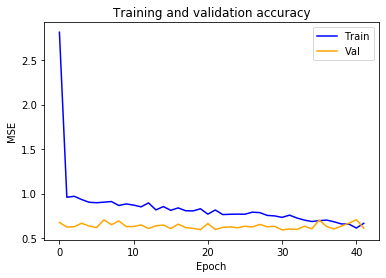

In [0]:
plot(history)

### Testing

In [0]:
model1_best = tf.keras.models.load_model('model-e031.ckpt')

In [0]:
from scipy import stats

In [0]:
pred1 = model1_best.predict(x=padded_test)
pred_arr = [p[0] for p in pred1]

d = np.subtract(np.array(pred_arr),y_test_std)
test_mse = np.mean(np.square(d))
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(abs(d))
test_pearsonr = stats.pearsonr(y_test_std, pred_arr)

print("Test Results on best model epoch")
print("RMSE:",test_rmse)
print("MAE:",test_mae)
print("Pearson R & P-value:",test_pearsonr)

Test Results on best model epoch
RMSE: 0.9685732333588796
MAE: 0.7746089153937775
Pearson R & P-value: (0.3400114970748387, 2.8950468124683984e-10)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil
#zip
if not os.path.exists('/content/drive/My Drive/DNNmodel1.zip'):
  model1_archive = shutil.make_archive('/content/drive/My Drive/DNNmodel1', 'zip', '/content/model-e031.ckpt')
  print(model1_archive)
  print(os.path.getsize(model1_archive)/1048576,"mb")
else:
  print('Zip archive exists')

/content/drive/My Drive/DNNmodel1.zip
34.164793968200684 mb


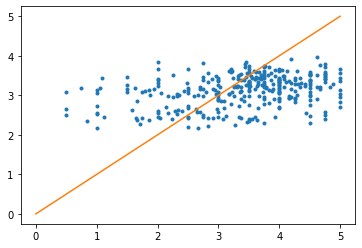

In [0]:
# Test Data Prediction
plt.plot(y_test_std, pred_arr, '.')
# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
plt.plot(x, x)
plt.show()

## Model 2 - More Nodes

In [121]:
model2 = Sequential()
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=EMBED_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQ_LEN,
                            #trainable=False
                            trainable=True
                           )
model2.add(embedding_layer)
model2.add(tf.keras.layers.SpatialDropout1D(0.3))
model2.add(Bidirectional(LSTM(256)))
"""model2.add(tf.keras.layers.Conv1D(128,
                 5,
                 padding='valid',
                 activation='relu',
                 strides=1))
model2.add(tf.keras.layers.GlobalMaxPooling1D())"""
#model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.2))
#model2.add(Dense(64, activation="relu"))
#model2.add(Dropout(0.2))
model2.add(Dense(1, activation=None))

model2.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 2000, 64)          1880192   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 2000, 64)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 512)               657408    
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 513       
Total params: 2,538,113
Trainable params: 2,538,113
Non-trainable params: 0
_________________________________________________________________


In [145]:
inp = Input(shape = (MAX_SEQ_LEN,))
x = Embedding(num_words, EMBED_DIM, weights = [embedding_matrix], trainable = False)(inp)
x1 = tf.keras.layers.SpatialDropout1D(0.3)(x)

x_gru = Bidirectional(GRU(128, return_sequences = True))(x1)
x1 = tf.keras.layers.Conv1D(32, kernel_size=4, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool1_gru = tf.keras.layers.GlobalAveragePooling1D()(x1)
max_pool1_gru = tf.keras.layers.GlobalMaxPooling1D()(x1)

x3 = tf.keras.layers.Conv1D(32, kernel_size=4, padding='valid', kernel_initializer='he_uniform')(x_gru)
avg_pool3_gru = tf.keras.layers.GlobalAveragePooling1D()(x3)
max_pool3_gru = tf.keras.layers.GlobalMaxPooling1D()(x3)

x_lstm = Bidirectional(LSTM(128, return_sequences = True))(x1)
x1 = tf.keras.layers.Conv1D(32, kernel_size=4, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool1_lstm = tf.keras.layers.GlobalAveragePooling1D()(x1)
max_pool1_lstm = tf.keras.layers.GlobalMaxPooling1D()(x1)

x3 = tf.keras.layers.Conv1D(32, kernel_size=4, padding='valid', kernel_initializer='he_uniform')(x_lstm)
avg_pool3_lstm = tf.keras.layers.GlobalAveragePooling1D()(x3)
max_pool3_lstm = tf.keras.layers.GlobalMaxPooling1D()(x3)


x = tf.keras.layers.concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.1)(Dense(64, activation='relu') (x))
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.1)(Dense(int(64 / 2), activation='relu') (x))
x = Dense(1, activation = None)(x)
model2 = Model(inputs = inp, outputs = x)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 2000)]       0                                            
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 2000, 64)     1880192     input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_10 (SpatialDr (None, 2000, 64)     0           embedding_33[0][0]               
__________________________________________________________________________________________________
bidirectional_33 (Bidirectional (None, 2000, 256)    148992      spatial_dropout1d_10[0][0]       
____________________________________________________________________________________________

In [0]:
model2.compile(loss='mse', optimizer='adam', metrics=['mse'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=11, verbose=0, mode='min')
cp_save = tf.keras.callbacks.ModelCheckpoint('model2-e{epoch:03d}.ckpt', 
                                             save_best_only=True, monitor='val_mse', mode='min')

In [147]:
history2 = model2.fit(padded_train, y_train_std, 
                     epochs=100, 
                     verbose=2, 
                     callbacks=[earlyStopping, cp_save],
                     validation_data=(padded_val,y_val_std))

Train on 1105 samples, validate on 196 samples
Epoch 1/100
INFO:tensorflow:Assets written to: model2-e001.ckpt/assets
1105/1105 - 45s - loss: 5.7711 - mse: 5.7711 - val_loss: 5.3432 - val_mse: 5.3432
Epoch 2/100
INFO:tensorflow:Assets written to: model2-e002.ckpt/assets
1105/1105 - 36s - loss: 1.7395 - mse: 1.7395 - val_loss: 2.7287 - val_mse: 2.7287
Epoch 3/100
1105/1105 - 14s - loss: 1.4383 - mse: 1.4383 - val_loss: 2.9775 - val_mse: 2.9775
Epoch 4/100
INFO:tensorflow:Assets written to: model2-e004.ckpt/assets
1105/1105 - 38s - loss: 1.2516 - mse: 1.2516 - val_loss: 1.7309 - val_mse: 1.7309
Epoch 5/100
INFO:tensorflow:Assets written to: model2-e005.ckpt/assets
1105/1105 - 36s - loss: 1.2310 - mse: 1.2310 - val_loss: 1.1215 - val_mse: 1.1215
Epoch 6/100
INFO:tensorflow:Assets written to: model2-e006.ckpt/assets
1105/1105 - 38s - loss: 1.1954 - mse: 1.1954 - val_loss: 0.9030 - val_mse: 0.9030
Epoch 7/100
1105/1105 - 14s - loss: 1.1200 - mse: 1.1200 - val_loss: 1.0657 - val_mse: 1.0657


In [0]:
model2_best = tf.keras.models.load_model('model2-e018.ckpt')

In [149]:
pred2 = model2_best.predict(x=padded_test)
pred2_arr = [p[0] for p in pred2]

d = np.subtract(np.array(pred2_arr),y_test_std)
test_mse = np.mean(np.square(d))
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(abs(d))
test_pearsonr = stats.pearsonr(y_test_std, pred2_arr)

print("Test Results on best model epoch")
print("RMSE:",test_rmse)
print("MAE:",test_mae)
print("Pearson R & P-value:",test_pearsonr)

Test Results on best model epoch
RMSE: 0.9631820033339726
MAE: 0.7962272976911802
Pearson R & P-value: (0.3924426208580274, 1.899277831042866e-13)


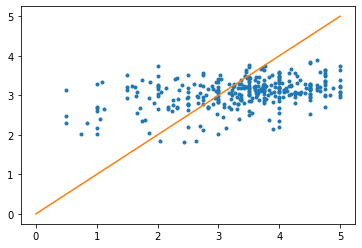

In [150]:
# Test Data Prediction
plt.plot(y_test_std, pred2_arr, '.')
# plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
plt.plot(x, x)
plt.show()